In [1]:
from IPython.core.display import display, HTML
display(HTML('''
<style>.container { width:85% !important; }</style>
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
'''))

In [2]:
%matplotlib inline
import gdax
from api_key import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams as rc
from datetime import datetime, timedelta
import time
from pprint import pprint
from gdax_helpers import *

In [3]:
auth_client = gdax.AuthenticatedClient(KEY,
                                       B64SECRET,
                                       PASSPHRASE)
res = get_portfolio_history(auth_client)

BTC-USD Starting 2017-12-19 22:37:14.513654
found BTC-USD data
from 2017-01-01 17:00:00
to   2018-01-11 01:00:00
Filling from
2018-01-11 01:00:00
to
2018-01-11 08:00:00
storing BTC-USD in prices.h5
ETH-USD Starting 2017-12-20 00:14:53.193794
found ETH-USD data
from 2017-07-05 18:00:00
to   2018-01-11 01:00:00
Filling from
2018-01-11 01:00:00
to
2018-01-11 08:00:00
storing ETH-USD in prices.h5


In [4]:
rc.update({'font.size': 18})
size=(23,13)

# Principal Graph

Text(50,-30,'$138.29\n12/22 07:00')

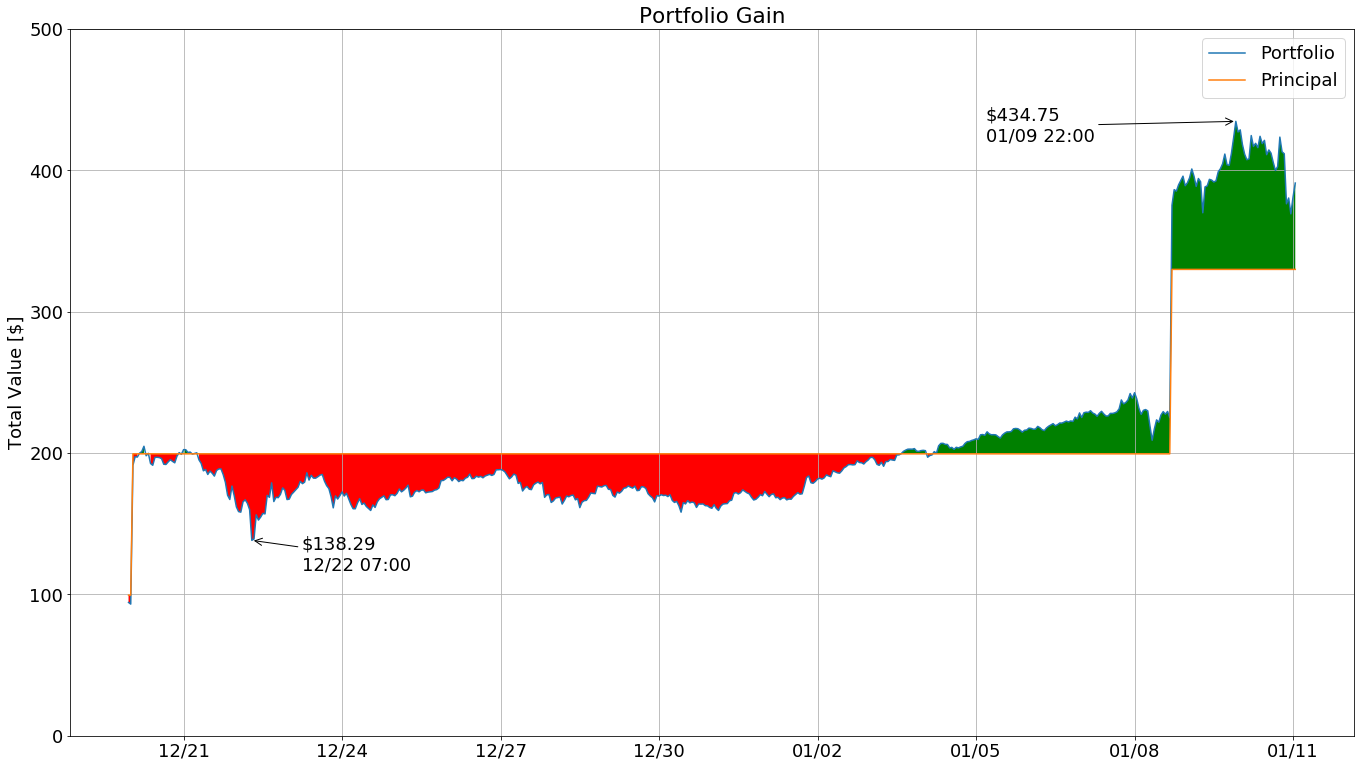

In [5]:
fig, ax = plt.subplots(figsize=size)
ax.grid(True)
ax.plot(res['total']['close'])
ax.plot(res['principal'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.legend(['Portfolio', 'Principal'], loc='upper right')
ax.set_title('Portfolio Gain')
ax.set_ylim(0, 500)
ax.set_ylabel('Total Value [$]')

y1 = res['principal'].values
y2 = res['total']['close'].values
ax.fill_between(
    x=res['principal'].index,
    y1=y1,
    y2=y2,
    where=y2 <= y1,
    facecolor='red'
)

ax.fill_between(
    x=res['principal'].index,
    y1=y1,
    y2=y2,
    where=y2 >= y1,
    facecolor='green'
)

data = res['total']['close']
ax.annotate('${:.2f}\n{}'.format(data.max(),
                                 data[data == data.max()].index[0].strftime('%m/%d %H:%M')),
            xy=(data[data == data.max()].index[0], data.max()),
            xycoords='data',
            xytext=(-250, -20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

min_val = data[data.index > '2017-12-21'].min()
min_index = data[data == min_val].index[0]
ax.annotate('${:.2f}\n{}'.format(min_val,
                                 min_index.strftime('%m/%d %H:%M')),
            xy=(min_index, min_val),
            xycoords='data',
            xytext=(50, -30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

# Portfolio Rate

Text(50,50,'-30.68%\n12/22 07:00')

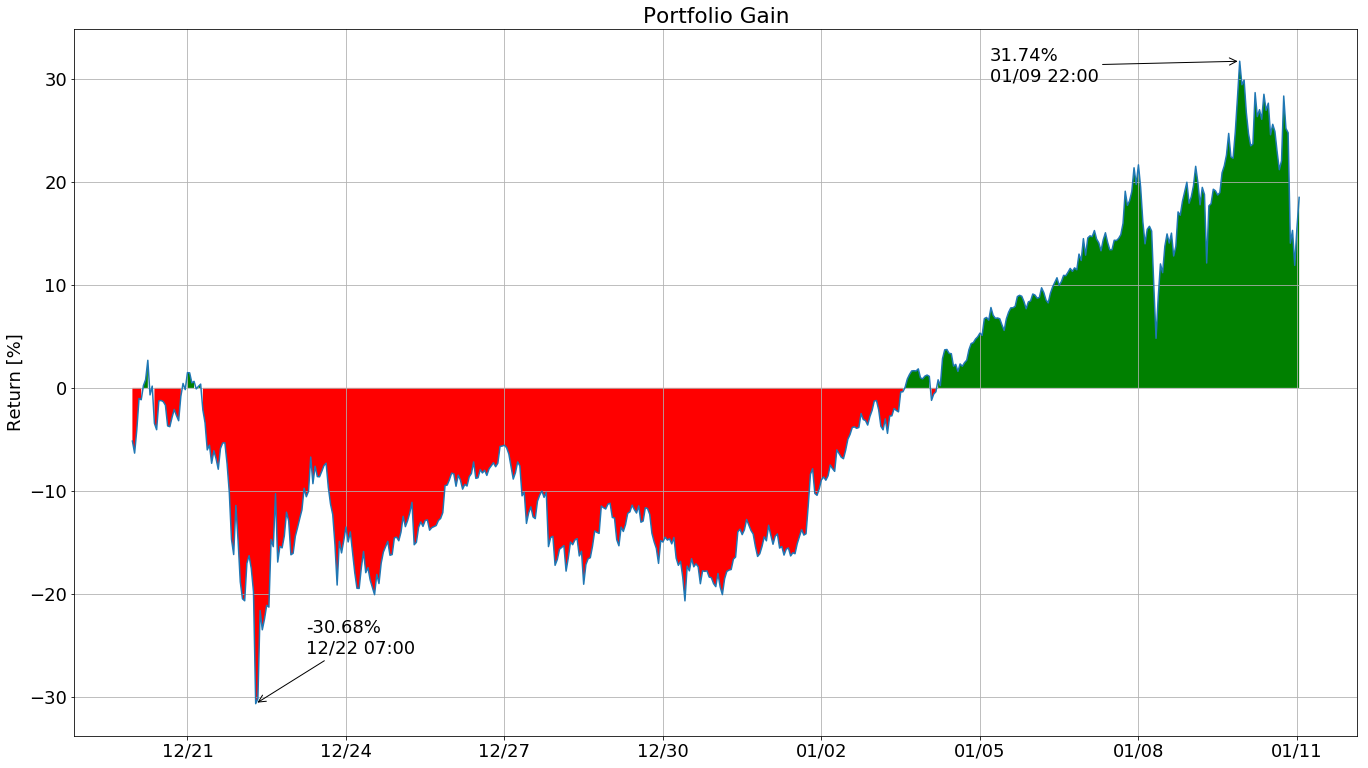

In [6]:
data = res['total']['close'].divide(res['principal'], axis=0) - 1
data *= 100
fig, ax = plt.subplots(figsize=size)
ax.grid(True)
ax.plot(data)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_title('Portfolio Gain')
ax.set_ylabel('Return [%]')

y1 = data.values
y2 = np.full((len(data.values)), 0)
ax.fill_between(
    x=data.index,
    y1=y1,
    y2=y2,
    where=y2 <= y1,
    facecolor='green'
)

ax.fill_between(
    x=data.index,
    y1=y1,
    y2=y2,
    where=y2 >= y1,
    facecolor='red'
)

ax.annotate('{:.2f}%\n{}'.format(data.max(),
                                 data[data == data.max()].index[0].strftime('%m/%d %H:%M')),
            xy=(data[data == data.max()].index[0], data.max()),
            xycoords='data',
            xytext=(-250, -20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

ax.annotate('{:.2f}%\n{}'.format(data.min(),
                                 data[data == data.min()].index[0].strftime('%m/%d %H:%M')),
            xy=(data[data == data.min()].index[0], data.min()),
            xycoords='data',
            xytext=(50, 50),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

# Portfolio Gain

Text(50,30,'$-61.21\n12/22 07:00')

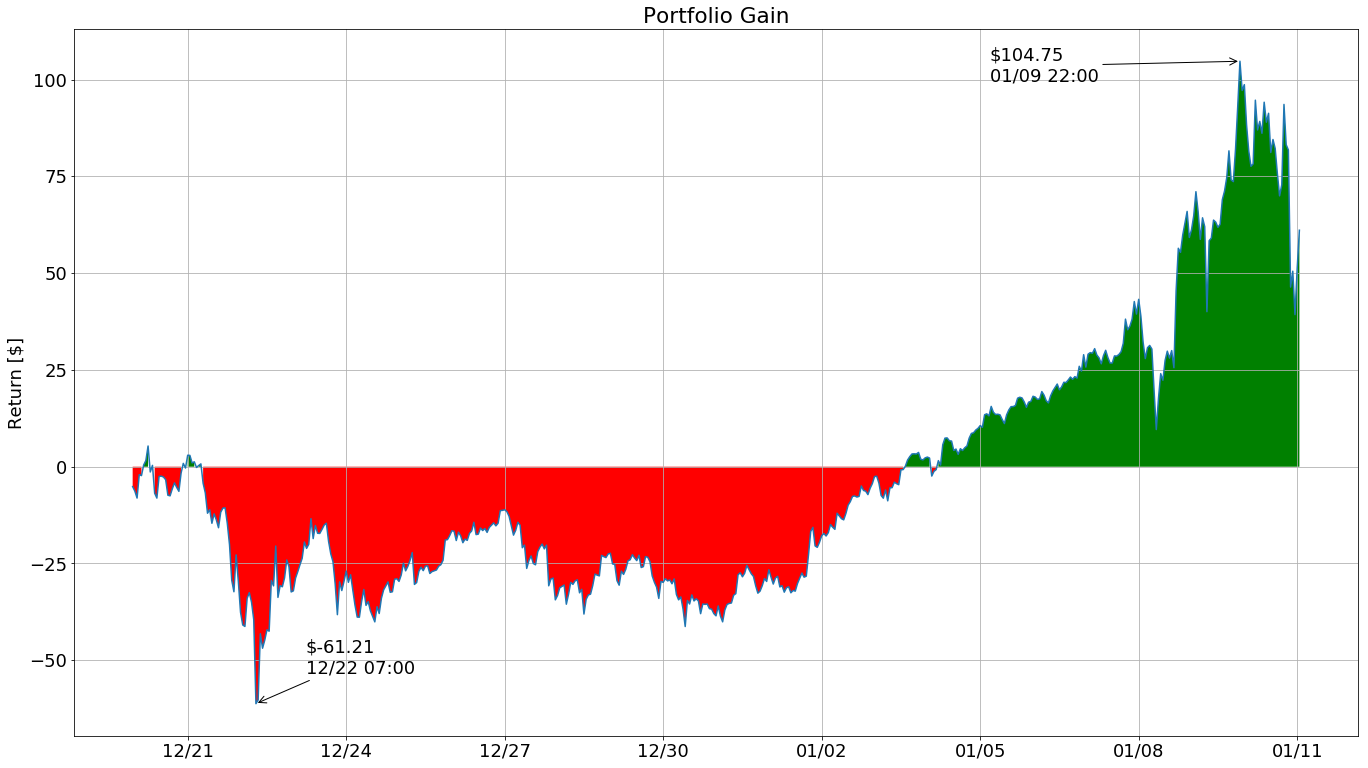

In [7]:
data = res['total']['close'].subtract(res['principal'], axis=0)
fig, ax = plt.subplots(figsize=size)
ax.grid(True)
ax.plot(data)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_title('Portfolio Gain')
# ax.set_ylim(-100, 100)
ax.set_ylabel('Return [$]')
y1 = data.values
y2 = np.full((len(data.values)), 0)
ax.fill_between(
    x=data.index,
    y1=y1,
    y2=y2,
    where=y2 <= y1,
    facecolor='green'
)

ax.fill_between(
    x=data.index,
    y1=y1,
    y2=y2,
    where=y2 >= y1,
    facecolor='red'
)


ax.annotate('${:.2f}\n{}'.format(data.max(),
                                 data[data == data.max()].index[0].strftime('%m/%d %H:%M')),
            xy=(data[data == data.max()].index[0], data.max()),
            xycoords='data',
            xytext=(-250, -20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

ax.annotate('${:.2f}\n{}'.format(data.min(),
                             data[data == data.min()].index[0].strftime('%m/%d %H:%M')),
            xy=(data[data == data.min()].index[0], data.min()),
            xycoords='data',
            xytext=(50, 30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))